# 월마트 부서별 매출 분석

기본 패키지 임포트

In [ ]:
import re, json
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
%matplotlib inline

In [90]:
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

## 데이터 읽기

In [91]:
path = "data/"

TRAIN = 'train.csv'
TEST = 'test.csv'
SAMPLE = 'sampleSubmission.csv'
FEATURE = 'features.csv'
STORE = 'stores.csv'

In [218]:
df_train = pd.read_csv(path + TRAIN)
df_test = pd.read_csv(path + TEST)
sample_df = pd.read_csv(path+SAMPLE)
feature_df = pd.read_csv(path+FEATURE)
store_df = pd.read_csv(path+STORE)

데이터 다운로드 확인

In [93]:
try:
    df_train.info()
    print("\n\n")
    df_test.info()
    print("\n\n")
    sample_df.info()
    print("\n\n")
    feature_df.info()
    print("\n\n")
    store_df.info()
except:
    print("error downloading file")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (tot

## 데이터 전처리

### 결측치 확인

<AxesSubplot:>

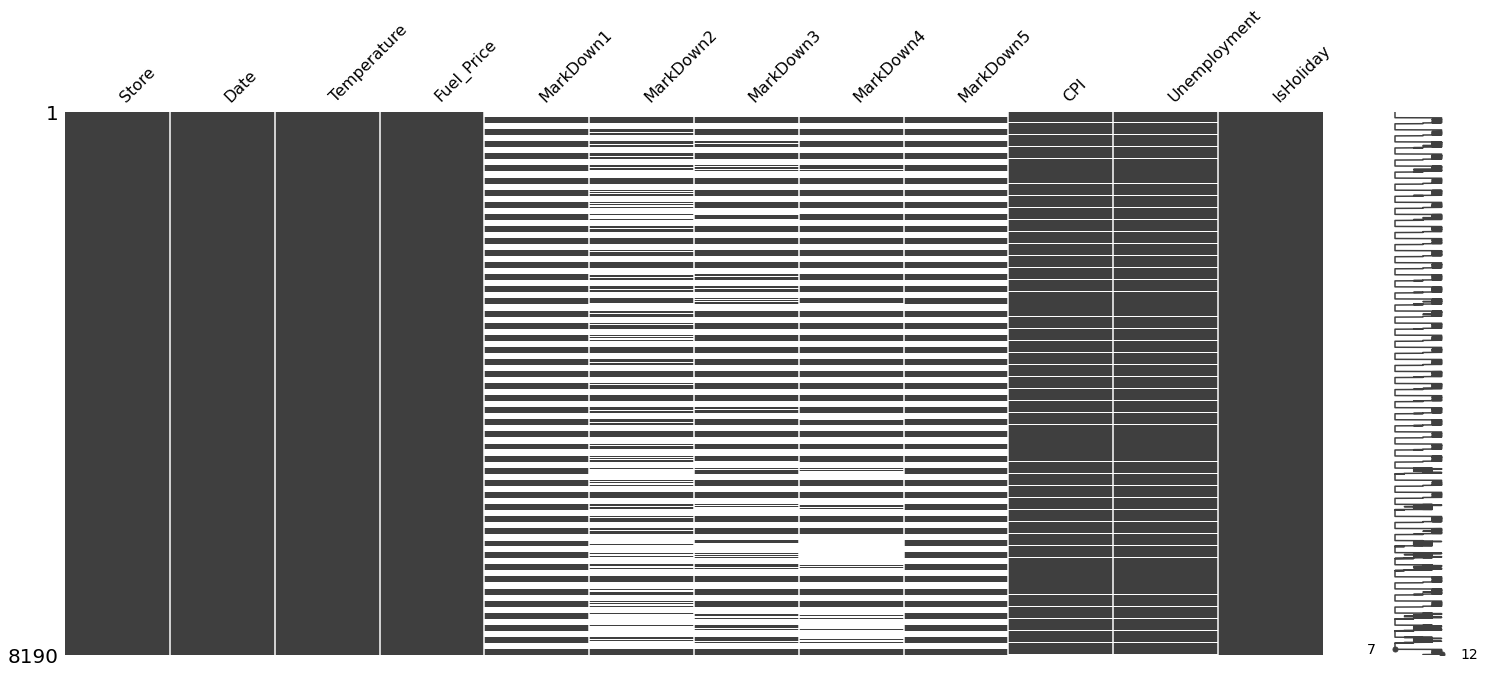

In [220]:
import missingno as msno
msno.matrix(feature_df)

### feature_df 특징별 결측률

In [221]:
all_data_na = (feature_df.isnull().sum() / len(feature_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
MarkDown2,64.334554
MarkDown4,57.704518
MarkDown3,55.885226
MarkDown1,50.769231
MarkDown5,50.549451
CPI,7.142857
Unemployment,7.142857


Markdown은 결측률이 너무 높으니 제거하자

In [94]:
feature_df = feature_df.drop("MarkDown1",axis=1)
feature_df = feature_df.drop("MarkDown2",axis=1)
feature_df = feature_df.drop("MarkDown3",axis=1)
feature_df = feature_df.drop("MarkDown4",axis=1)
feature_df = feature_df.drop("MarkDown5",axis=1)

### CPI, Unemployment 처리

CPI는 시간에 따라서 증가, Unemployment는 시간에 따라서 감소한다
따라서 가장 최신 값으로 대체한다 (결측값은 최신시점임)

In [230]:
recent_CPI = feature_df[~feature_df['CPI'].isna()]['CPI'].tolist()[-1] #가장 최근값
recent_Unemployment = feature_df[~feature_df['Unemployment'].isna()]['Unemployment'].tolist()[-1] #가장 최근값

In [96]:
feature_df.loc[feature_df['CPI'].isna(), 'CPI'] = recent_CPI
feature_df.loc[feature_df['Unemployment'].isna(), 'Unemployment'] = recent_Unemployment

In [97]:
dataset = df_train.merge(store_df, how='left').merge(feature_df, how='left')

In [98]:
dataset_test = df_test.merge(store_df, how='left').merge(feature_df, how='left')

In [99]:
dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,192.330854,8.667


In [100]:
#날짜를 년/월/일로 구분
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Day'] = pd.to_datetime(dataset['Date']).dt.day

dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])
dataset_test['Year'] = pd.to_datetime(dataset_test['Date']).dt.year
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test['Day'] = pd.to_datetime(dataset_test['Date']).dt.day


#문자를 숫자로 인덱싱
dataset.replace({'A': 1, 'B': 2,'C':3},inplace=True)
dataset_test.replace({'A': 1, 'B': 2,'C':3},inplace=True)

In [101]:
dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,1,1,2010-02-05,24924.50,False,1,151315,42.31,2.572,211.096358,8.106,2010,2,5
1,1,1,2010-02-12,46039.49,True,1,151315,38.51,2.548,211.242170,8.106,2010,2,12
2,1,1,2010-02-19,41595.55,False,1,151315,39.93,2.514,211.289143,8.106,2010,2,19
3,1,1,2010-02-26,19403.54,False,1,151315,46.63,2.561,211.319643,8.106,2010,2,26
4,1,1,2010-03-05,21827.90,False,1,151315,46.50,2.625,211.350143,8.106,2010,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2,118221,64.88,3.997,192.013558,8.684,2012,9,28
421566,45,98,2012-10-05,628.10,False,2,118221,64.89,3.985,192.170412,8.667,2012,10,5
421567,45,98,2012-10-12,1061.02,False,2,118221,54.47,4.000,192.327265,8.667,2012,10,12
421568,45,98,2012-10-19,760.01,False,2,118221,56.47,3.969,192.330854,8.667,2012,10,19


## 학습

In [103]:
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

In [104]:
drop_list = ['Weekly_Sales','Date','IsHoliday']
X = dataset.drop(drop_list,axis=1)
y = dataset['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [105]:
X.dtypes

Store             int64
Dept              int64
Type              int64
Size              int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Year              int64
Month             int64
Day               int64
dtype: object

In [187]:
obj_like_cols = ['Type','Date']
train = dataset.drop(obj_like_cols, axis = 1)
test = dataset_test.drop(obj_like_cols, axis = 1)
cat_cols = test.select_dtypes('category').columns
train[cat_cols] = train[cat_cols].astype('int64')
test[cat_cols] = test[cat_cols].astype('int64')
train[train.select_dtypes('uint8').columns] = train[train.select_dtypes('uint8').columns].astype('int')
test[test.select_dtypes('uint8').columns] = test[test.select_dtypes('uint8').columns].astype('int')
cols_to_scale = train.select_dtypes(['int', 'float']).drop(['Weekly_Sales'], axis=1).columns
scaler = preprocessing.StandardScaler().fit(train[cols_to_scale])
train[cols_to_scale] = scaler.transform(train[cols_to_scale])

In [194]:
obj_like_cols = ['Type','Date']
train = dataset.drop(obj_like_cols, axis = 1)
test = dataset_test.drop(obj_like_cols, axis = 1)

In [195]:
def WMAE(y, y_pred, isholiday):
    W = np.ones(y_hat.shape)
    W[isholiday == 1] = 5
    metric = (1/np.sum(W))*np.sum(W*np.abs(y-y_hat))

    return metric

In [199]:
drop_list = ['Weekly_Sales']
X = train.drop(drop_list,axis=1)
y = train["Weekly_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
352966,37,93,False,39910,70.48,3.845,220.045486,7.244,2012,3,30
78879,9,2,False,125833,91.63,3.638,219.192985,6.404,2011,8,12
219024,23,17,False,114533,29.44,3.638,134.068258,4.781,2011,4,1
41923,5,16,False,34875,86.96,3.494,222.547299,5.603,2012,8,10
409386,44,72,False,39910,82.27,2.797,126.128355,7.804,2010,7,23
...,...,...,...,...,...,...,...,...,...,...,...
360880,38,97,False,39690,67.41,3.727,129.793677,12.890,2011,10,28
13747,2,26,False,202307,45.99,3.261,219.532820,7.057,2012,1,13
250263,26,25,False,152513,22.53,3.413,136.588387,7.598,2011,12,23
249214,26,18,False,152513,52.47,2.718,132.761933,8.445,2010,9,24


In [200]:
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    #'extraTreesRegressor': ExtraTreesRegressor(n_estimators=100, max_features='auto', random_state=1),
    #이 모델 쓰려다가 메모리 터져서 지움;;;;
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=1)
}
yhats = {}
res = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    yhats[model_name] = y_hat
    wmae = WMAE(X_test.IsHoliday, y_test, y_hat)
    mae = mean_absolute_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    res[model_name] = (model, wmae, r2)
    print(f'{model_name}:')
    print(f'WMAE = {wmae} and R-square = {r2} and MAE = {mae}')

DecisionTreeRegressor:
WMAE = 15958.31190025486 and R-square = 0.9571873340915257 and MAE = 1827.785466017667
RandomForestRegressor:
WMAE = 16005.049592383746 and R-square = 0.9766889519759514 and MAE = 1388.0514068192385


In [202]:
def wmae2(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [204]:
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    #'extraTreesRegressor': ExtraTreesRegressor(n_estimators=100, max_features='auto', random_state=1),
    #이 모델 쓰려다가 메모리 터져서 지움;;;;
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=1)
}
yhats = {}
res = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    yhats[model_name] = y_hat
    wmae = wmae2(X_test, y_test, y_hat)
    mae = mean_absolute_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    res[model_name] = (model, wmae, r2)
    print(f'{model_name}:')
    print(f'WMAE = {wmae} and R-square = {r2} and MAE = {mae}')

DecisionTreeRegressor:
WMAE = 2054.33 and R-square = 0.9571873340915257 and MAE = 1827.785466017667
RandomForestRegressor:
WMAE = 1569.83 and R-square = 0.9766889519759514 and MAE = 1388.0514068192385


In [208]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor(learning_rate=0.01, n_estimators=500, \
                       objective='reg:squarederror', random_state = 31)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=31,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [214]:
def evaluation(model, train_x, train_y, val_x, val_y):
    cv = cross_val_score(model, train_x, train_y, cv = 10)
    y_pred = model.predict(val_x)
    cv = np.mean(cv)
    r2=r2_score(y_pred, val_y)
    wmae = wmae2(val_x, val_y, y_pred)
    
    return cv, r2, wmae

In [215]:
result = evaluation(xgb, X_train, y_train, X_test, y_test)

In [216]:
result

(0.8551440115168425, 0.7857110170077525, 5216.64)

마지막이 WMAE!

In [201]:
random_yhat = yhats['RandomForestRegressor']
decision_yhat = yhats['DecisionTreeRegressor']

In [116]:
testCheck = pd.DataFrame({'actual' : y_test, 'random_yhat':random_yhat, 'decision_yhat':decision_yhat})
testCheck

,actual,random_yhat,decision_yhat
186824,84213.77,88785.3666,86260.83
184191,548.67,554.9950,426.34
183869,3582.12,2458.9271,2225.38
162617,51197.86,48836.5011,48510.15
313576,82427.21,87204.1776,79827.93
...,...,...,...
191050,616.35,550.3569,642.11
128973,34938.07,36851.4969,36740.96
212922,28839.21,25566.5637,25740.81
150372,22229.50,21432.6109,16164.04


랜덤포레스트 모델 예측값 비교


[]

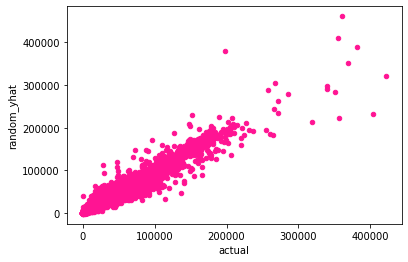

In [142]:
print("랜덤포레스트 모델 예측값 비교")
scatter_plot=testCheck.plot.scatter(x='actual',y='random_yhat', c= 'deeppink')
scatter_plot.plot()

결정트리 모델 예측값 비교


[]

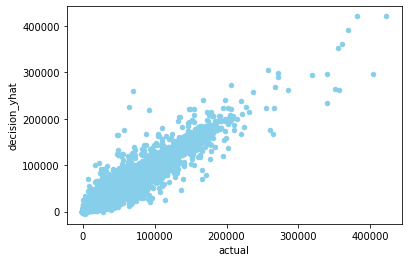

In [143]:
print("결정트리 모델 예측값 비교")
scatter_plot=testCheck.plot.scatter(x='actual', y='decision_yhat', c='skyblue')
scatter_plot.plot()

In [140]:
print("=======랜덤포레스트=======")
sub = abs(testCheck['actual']-testCheck['random_yhat'])
print("오차가 100 비율 : {:.2f}%".format(len([x for x in sub if x<100])/len(sub)*100))
print("오차가 1000 비율 : {:.2f}%".format(len([x for x in sub if x<1000])/len(sub)*100))
print("오차가 5000 비율 : {:.2f}%".format(len([x for x in sub if x<5000])/len(sub)*100))
print("오차가 10000미만인 비율 : {:.2f}%".format(len([x for x in sub if x<10000])/len(sub)*100))

=======랜덤포레스트=======
오차가 100 비율 : 20.26%
오차가 1000 비율 : 66.49%
오차가 5000 비율 : 94.67%
오차가 10000미만인 비율 : 98.40%


In [141]:
print("=======결정트리=======")
sub = abs(testCheck['actual']-testCheck['decision_yhat'])
print("오차가 100 비율 : {:.2f}%".format(len([x for x in sub if x<100])/len(sub)*100))
print("오차가 1000 비율 : {:.2f}%".format(len([x for x in sub if x<1000])/len(sub)*100))
print("오차가 5000 비율 : {:.2f}%".format(len([x for x in sub if x<5000])/len(sub)*100))
print("오차가 10000미만인 비율 : {:.2f}%".format(len([x for x in sub if x<10000])/len(sub)*100))

=======결정트리=======
오차가 100 비율 : 17.71%
오차가 1000 비율 : 60.53%
오차가 5000 비율 : 91.94%
오차가 10000미만인 비율 : 97.16%
